# Section 8: Maps and Power Spectra of Individual patches (Power Spectrum Stand in Notebook)

This notebook provides an overview of the individual patch maps included as part of the Advanced ACT data release 4 (DR4).

To return to the main notebook or to view a different section use the links in the table of contents.

## Table of contents

 --- 
> [Section 1](Section_1_Advanced_ACT_DR4_Combined_data_products.ipynb): Introduction and Importing Pixell, Healpy and other key packages

> [Section 2](Section_2_coadded_maps.ipynb): S08-18 Coadded maps and an Introduction to Pixell

> [Section 3](Section_3_HEALPix_CAR_Conversions.ipynb):  Demonstration of methods to converted maps between HEALPix format and the CAR format.

> [Section 4](Section_4_visualize_objects.ipynb):  Guide to using Pixell to look at objects in the maps and stacking our maps on catalogue positions.

> [Section 5](Section_5_Lensing_maps.ipynb):  Introduction to the Lensing maps.

> [Section 6](Section_6_Component_separated_maps.ipynb):  Guide to the use of the Component Separated maps.

> [Section 7](Section_7_harmonic_analysis.ipynb):  Harmonic Analysis with CAR Maps

> [Section 8](Section_8_power_spectrum.ipynb): Maps and Power Spectra of Individual Patches 

> [Section 9](Section_9_E_B_maps.ipynb):  Looks at how to generate E and B maps from I, Q, U maps.  
---


## Import packages and set the data path

This cell will import pixell and healpy packages.  If you're using this notebook with a Docker container running the container should handle the package instalation.  If not please consult the documentation to install [Pixell](https://github.com/simonsobs/pixell) and [Healpy](https://healpy.readthedocs.io/en/latest/) seperately.

In [5]:
import numpy as np
import matplotlib.pyplot as plt
import healpy as hp
import time
import sys
from pixell import enmap, enplot, reproject,utils, curvedsky 
from matplotlib import cm

path = "data/"

# Accessing the available map splits

The season 13 through 16 maps cover ~ 17,000 sq degrees on the sky and we present both 98 GHz and 150 GHz maps. They include data used to make the maps presented in Naess et al. (2014) and Louis et al. (2017) along with sumplemental observations from 2015 and 2016. While we will only use the data from the D8 patch in this particular notebook the rest of the patch, array, season and frequncy combinations are detailed in Table 1.

---
Table 1: Summary of patch sizes and white-noise levels
---



Season | s13|s14|s15|s16
---|---|---|---|---
**Array and Frequency** | **PA1$_{150}$** | **PA1$_{150}$/ PA2$_{150}$**|  **PA1$_{150}$**/ **PA2$_{150}$/PA3$_{98}$ / PA3$_{150}$**| **PA2/PA3$_{98}$/PA3$_{150}$**
**D1 (131 sq deg)**| 18.6 | | |
**D5 (157 sq deg)** | 16.4 
**D6 (135 sq deg)**| 12.6|
**D56 (834 sg deg)**| | 32.3/20.5 | 33.3/21.9/18.4/28.6|
**D8 (248 sq deg)**| | | 42.0/21.5/20.0/29.0|
**BN (3157 sq deg)**| | |76.8/41.3/33.9/49.1
**AA (17044 sq deg)** | | || 72.9/78.7/118.5

White noise levels are given in units of $\mu$K-arcmin.

---

For each of the patch, season, array and frequency combination we include 4 splits (with the exception of patch AA which includes 2). As well as one map-based co-add resulting in 94 data units.  

Each of these units contains 4 fits files:
 * Source-free maps:  These contain I (or T), Q and U Stokes components and ar in units of $\mu K_{CMB}$ 
 * Source maps:  These contain the point-source signal in units of $\mu K_{CMB} $ .  The simple sum of the source and source-free maps will give a map of the observed sky.
 * ivar (inverse-variance) maps: Roughly proportional to a traditinoal hit count map but includes the variability in detector performances and so is better suited for map-based weighting for map co-addition.
 * Cross-linking maps: T, Q, U components that are used to describe the cross-linking of a dataset.  

---
Maps are named according to the convention:
> act_dr4_season\*\_patch\*\_array\*\_freq\*\_nohwp_night_3pass_set\*\_map_suffix\*

* Season: s13, s14, s15, s16
* patch: D1, D5, D6, D56, D8, BN, AA
* array: PA1, PA2, PA3
* freq: f090, f150
* set: 2way_set0, 2way_set1 or 4way_set(0 - 4)
* map_suffix: map_srcfree.fits, srcs.fits, xlink.fits, ivar.fits

Once the splits of interest have been chosen they can be read in and viewed using Pixell's enmap as shown in the following example.

For this example we use the D8 patch at 150 GHz.

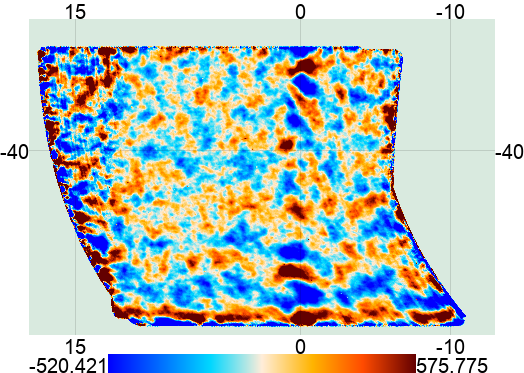

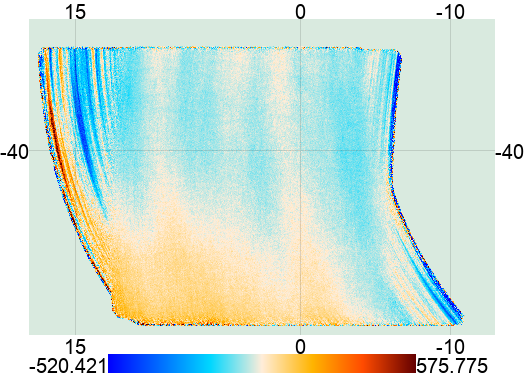

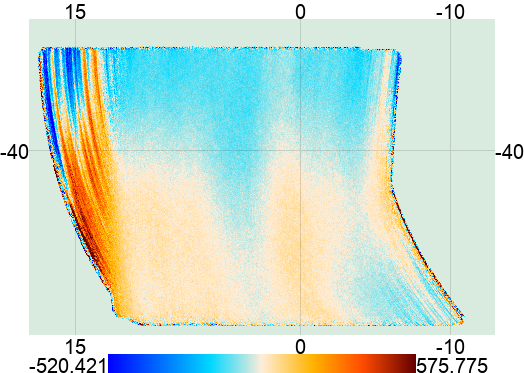

In [6]:
# We will select two maps of the same area, frequency, etc. one of which is source free
# and the other contains just the sources.  
fname_srcfree = "act_dr4_s15_D8_pa2_f150_nohwp_night_3pass_4way_set2_map_srcfree.fits"
fname_src = "act_dr4_s15_D8_pa2_f150_nohwp_night_3pass_4way_set2_srcs.fits"

# By combining the two maps chosen above we recover the observed sky with point sources
imap_srcfree = enmap.read_map(path + fname_srcfree)
imap_srcs =   enmap.read_map(path + fname_src)
imap = imap_srcfree + imap_srcs

# We can now plot the maps we just read in
def eshow(x,**kwargs): 
    ''' Define a function to help us plot the maps neatly '''
    plots = enplot.get_plots(x, **kwargs)
    enplot.show(plots, method = "ipython")

eshow(imap, **{"downgrade": 8, "colorbar": True, "ticks": 25})

Note that in the above map we actually see three maps.  The first is the I (or T) map and the next two are Q and U respectively.  To access just the temperature map, or just the Q or U maps, one can use normal array indexing.  We can also use indexing or enmap's submap feature to view a smaller patch of the map.  

Submaps are referenced by defining a bounding box according to :
> box = [[dec_from, ra_from],[dec_to, ra_to]] $\quad$ (in radians)


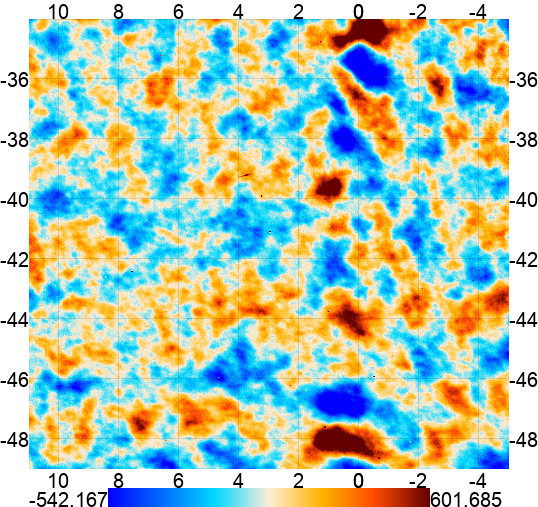

In [7]:
# Define a box to trim the map
box = np.array([[-49,11],[-34,-5]])*utils.degree

# Trim the maps using the submap feature
smap = imap.submap(box)

# Display just the intensity map using numpy array indexing (I = 0, Q = 1, U = 2)
eshow(smap[0], **{"downgrade": 4, "colorbar": True, "ticks": 2})


# Section 3: Cross Spectra of patches 

Given that each patch has multiple splits we are able to calculate simple cross spectra of patches. 

In this example we will read in two different sets for the same patch, freqeuncy etc.  We also choose to leave out the point sources.

The basic steps for this are:


1.   Read in the maps of interest
2.   Trim as needed to exclude noisy regions 
3.   Generate alms from the two patches
4.   Cross correlate to get the cls
5.   Adjust cls by accounting for the sky fraction (w2_new) and convert from cls to Dls




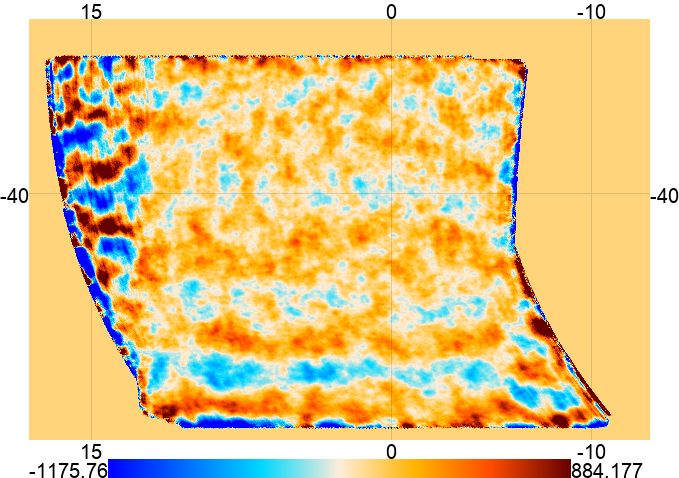

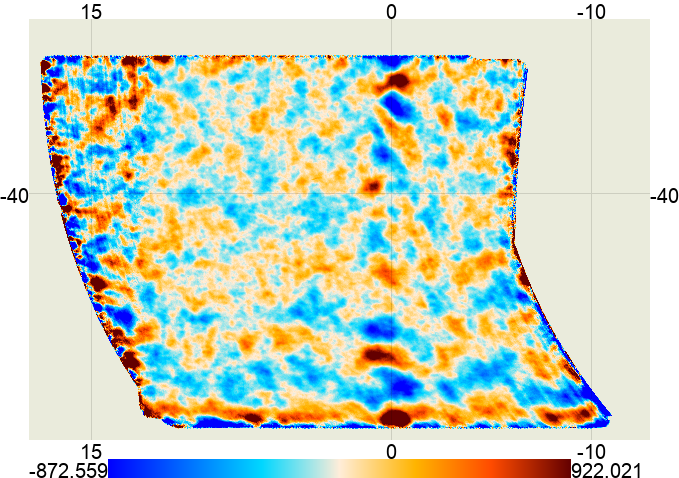

In [8]:
# We will read in another map of this same patch from earlier.  This time let's
# leave the point sources out   
fname_srcfree_1 = "act_dr4_s15_D8_pa2_f150_nohwp_night_3pass_4way_set1_map_srcfree.fits"
fname_srcfree_2 = "act_dr4_s15_D8_pa2_f150_nohwp_night_3pass_4way_set2_map_srcfree.fits"
fname_srcs = "act_dr4_s15_D8_pa2_f150_nohwp_night_3pass_4way_set2_srcs.fits"

# By combining the two maps chosen above we recover the observed sky with point sources
imap_srcfree_1 = enmap.read_map(path + fname_srcfree_1) 
imap_srcfree_2 = enmap.read_map(path + fname_srcfree_2) 

# We can now plot the maps we just read in
eshow(imap_srcfree_1[0], **{"downgrade": 6, "colorbar": True, "ticks": 25})
eshow(imap_srcfree_2[0], **{"downgrade": 6, "colorbar": True, "ticks": 25})

We can trim these patches again

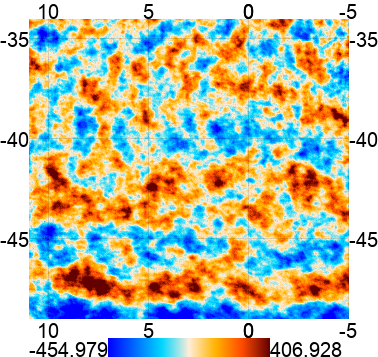

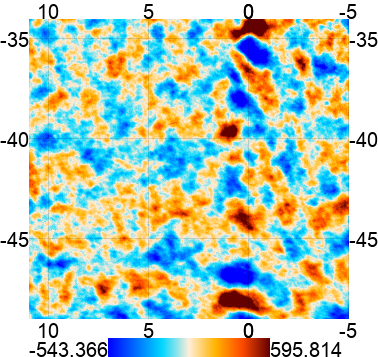

In [9]:
box = np.array([[-49,11],[-34,-5]])*utils.degree
smap_1 = imap_srcfree_1.submap(box)[0]
smap_2 = imap_srcfree_2.submap(box)[0]

eshow(smap_1, **{"downgrade": 6, "colorbar": True, "ticks": 5})
eshow(smap_2, **{"downgrade": 6, "colorbar": True, "ticks": 5})

Now we repeat the spherical harmonic analysis but with a cross spectra

In [10]:
# First we get the alms
alms_1 = np.cdouble(curvedsky.map2alm(smap_1, lmax = 6000))
alms_2 = np.cdouble(curvedsky.map2alm(smap_2, lmax = 6000))

# Next step we get the cls using healpy
cls = hp.alm2cl(alms_1, alms_2)

# We also want the corresponding ells which we can get easily
ell = np.arange(len(cls))

# Now we calculate the weighting we have to apply to our spectrum due to the 
# trimmed size
w2 = enmap.area(smap_1.shape, smap_1.wcs) /4. / np.pi

# Now we combine these to get the Dls
Dl = cls*ell **2/ w2 

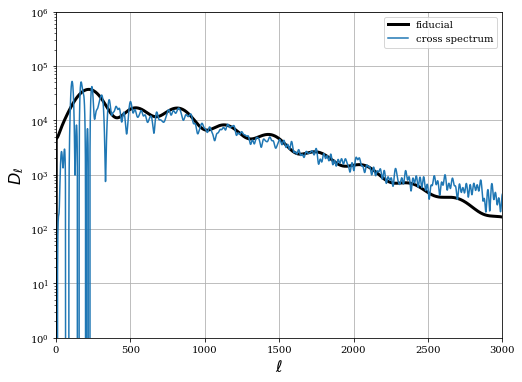

In [12]:
# Read in a camb fiducial spectrum for comparison
from pixell import powspec
camb_theory = powspec.read_spectrum(path + "camb_theory.dat")
cltt = camb_theory[0,0,:3000]
ls = np.arange(cltt.size)

# Now we can plot our power spectrum
plt.figure(figsize = (8,6))
plt.rc('font', family='serif')
plt.grid(True)

# Plot auto, cross and camb
plt.plot(ls,cltt*ls**2.,lw=3,color='k', label = "fiducial")
plt.plot(ell, Dl , label = "cross spectrum")
plt.legend()
plt.yscale('log')
plt.xlabel('$\\ell$', fontsize = 16)
plt.ylabel('$D_{\\ell}$', fontsize = 16)
plt.ylim(1 ,1e6)
plt.xlim(0, 3000)
plt.show()

This looks reasonably good now.  We can see the acoustic oscilations in power spectrum and it seems to match our fiducial plot reasonably well.  

While this method works really well for quick powerspectrum tests and for some analyses it's worth noting that their are limitations to it.  We haven't taken into account the fact that the mask we applied by trimming the map has second order effects on the power spectrum and will actually couple modes.  For that reason more in depth power spectrum analysis should use mask deconvolution algroithms such as **namaster**, **pitas** or **pspy**.

# Section 4: Beams


As part of DR4 beam information is readily available and should be used when doing powerspectrum analysis.  Here we demonstrate how to access these beams and generate window functions by squaring and normalizing them.

In [13]:
# Load the data
beam_fname = path + "s15_pa2_f150_nohwp_night_beam_tform_instant_cmbspec.txt"
data = np.loadtxt(beam_fname).T
ell, Bell = data[:2,:12001]

# Convert to window funciton
Well = Bell**2

# Apply normalization
norm = Well[0]
Well /= norm

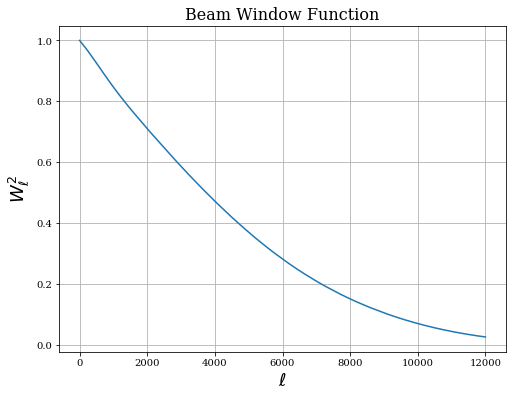

In [14]:
# Now we can plot the normalized beam window function
plt.figure(figsize = (8,6))
plt.rc('font', family='serif')

plt.plot(ell, Well)

plt.title("Beam Window Function", fontsize = 16)
plt.xlabel('$\\ell$', fontsize = 18)
plt.ylabel('$W_{\\ell}^2$', fontsize = 18)
plt.grid(True)
plt.show()

### Continue to the Next Section


[Section 9](Section_9_E_B_maps.ipynb):  Looks at how to generate E and B maps from I, Q, U maps.  